Imports

In [2]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# importing custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.data.load_data import load_data

from src.data.load_data import load_data

Loading in the raw data with custom function

In [3]:
train_df, test_df= load_data(raw=True)

Creation of the target variable.

In [4]:
y_test = np.log1p(test_df["ClaimNb"] / test_df["Exposure"])
y_train = np.log1p(train_df["ClaimNb"] / train_df["Exposure"])

We preprocess the training and test feature dataframes by:
- Splitting columns into numeric, ordinal, and nominal (one-hot) groups.  
- Treating `VehPower` and `Area` as ordinal features with explicitly defined value orderings.  
- Applying a numeric pipeline (standard scaling), an ordinal pipeline (`OrdinalEncoder`), and a one-hot pipeline (dense `OneHotEncoder`).  
- Fitting a `ColumnTransformer` on `X_train` and transforming both `X_train` and `X_test`.
> Essentially we dont apply any feature engineering, just make the data workable

In [5]:
def preprocess(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
):
    X_train = X_train.copy()
    X_test  = X_test.copy()

    cat_all = X_train.select_dtypes(include=["object","category","string","bool"]).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in cat_all]

    ord_cols = []
    ord_categories = []

    num_cols.remove("VehPower")
    unique_vals = pd.Series(X_train["VehPower"]).dropna().unique()
    unique_vals_num = pd.to_numeric(unique_vals, errors="raise")
    vehpower_order = sorted(unique_vals_num.tolist())
    ord_cols.append("VehPower")
    ord_categories.append(vehpower_order)

    area_order = sorted(pd.Series(X_train["Area"]).dropna().astype(str).unique().tolist())
    ord_cols.append("Area")
    ord_categories.append(area_order)
    if "Area" in cat_all:
        cat_all.remove("Area")

    ohe_cols = [c for c in cat_all if c not in ord_cols]

    num_pipe = Pipeline([
        ("scale", StandardScaler(with_mean=True, with_std=True)),
    ])

    ord_pipe = Pipeline([
        ("ord", OrdinalEncoder(
            categories=ord_categories,
            handle_unknown="use_encoded_value",
            unknown_value=-1
        )),
    ]) if ord_cols else "drop"

    ohe_pipe = Pipeline([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)),
    ]) if ohe_cols else "drop"

    transformers = []
    transformers.append(("num", num_pipe, num_cols))
    transformers.append(("ord", ord_pipe, ord_cols))
    transformers.append(("ohe", ohe_pipe, ohe_cols))

    pre = ColumnTransformer(transformers=transformers, remainder="drop")

    X_train = pre.fit_transform(X_train)
    X_test  = pre.transform(X_test)

    print(f"Train: {X_train.shape} | {'sparse' if sparse.isspmatrix(X_train) else 'dense'}")
    print(f"Test : {X_test.shape}  | {'sparse' if sparse.isspmatrix(X_test) else 'dense'}")
    print("Numeric:", len(num_cols), "| Ordinal:", len(ord_cols), "| OHE:", len(ohe_cols))
    print("VehPower order:", ord_categories[ord_cols.index("VehPower")])
    print("Area order:", ord_categories[ord_cols.index("Area")])

    return X_train, X_test, pre, {"num": num_cols, "ord": ord_cols, "ohe": ohe_cols}

We fit a PCA model on the training feature matrix to analyze how many principal components are needed to keep a certain amount of variance explained. It:
- Runs PCA with up to `n_features - 1` components.  
- Computes the cumulative sum of explained variance.  
- Plots the cumulative explained variance against the number of components.  
- Returns the reducer, the cumulative curve, and the smallest number of components needed to reach the target cumulative variance.

In [6]:
def elbow_on_train(X_train: int, randomized: bool, seed: int, target: float):
    reducer = PCA(
        n_components=X_train.shape[1]-1,
        svd_solver="randomized",
        iterated_power=7 if randomized else "auto",
        random_state=seed
    )
    
    reducer.fit(X_train)
    evr = reducer.explained_variance_ratio_
    cum = np.cumsum(evr)
    
    plt.figure()
    plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
    plt.xlabel("k components")
    plt.ylabel("Cumulative explained variance")
    plt.title(("PCA") + " Elbow (train only)")
    plt.grid(True)
    plt.show()

    return reducer, cum, int(np.searchsorted(cum, target) + 1)

We then run the full preprocessing and PCA dimensionality-reduction pipeline:
- Apply the preprocessing.  
- Compute k.  
- Refit PCA with the obtained k and create the transormed data.
- We print the kept varianec kept.

Train: (542410, 44) | dense
Test : (135603, 44)  | dense
Numeric: 7 | Ordinal: 2 | OHE: 3
VehPower order: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Area order: ['A', 'B', 'C', 'D', 'E', 'F']


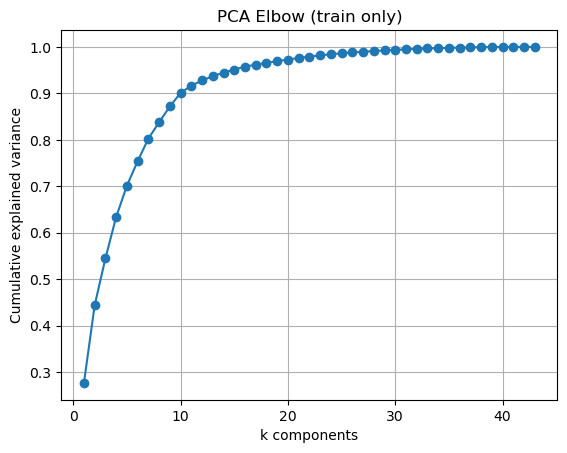

Z_train shape: (542410, 10) Z_test shape: (135603, 10)
Cumulative variance kept: 0.9009662337905378


In [7]:
X_train, X_test, pre, col = preprocess(train_df, test_df)
probe, cum, k = elbow_on_train(X_train, True, 42, 0.9)
reducer = PCA(n_components=k, svd_solver="randomized", iterated_power=7, random_state=42)

Z_train = reducer.fit_transform(X_train)
Z_test = reducer.transform(X_test)

evr_final = reducer.explained_variance_ratio_
print("Z_train shape:", Z_train.shape, "Z_test shape:", Z_test.shape)
print("Cumulative variance kept:", float(np.cumsum(evr_final)[-1]))

Defining a function to visualize the PCA-reduced data in 2D using the first two principal components.
Create the coloring with the use of the target.

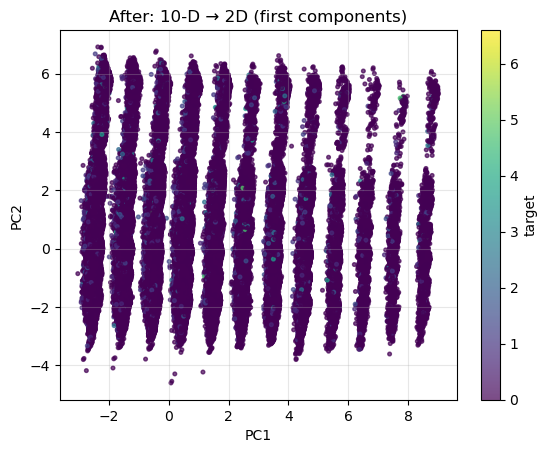

In [8]:
def plot_2d_from_pca(Z, y, title="After PCA (first 2 comps)"):
    plt.figure()
    sc = plt.scatter(Z[:, 0], Z[:, 1], c=y, s=7, alpha=0.7)
    plt.colorbar(sc, label="target")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_2d_from_pca(Z_train, y_train, title=f"After: {k}-D → 2D (first components)")

> Clustering

Estimates a suitable number of clusters for KMeans by scanning over different `k` values on a subsampled PCA space:
- Subsample the data for computational efficiency.
- For each `k` in `[k_min, k_max]`, fits a KMeans model, records its inertia, and computes the silhouette score on the subsample.  
- Plots both the inertia curve and the silhouette curve side by side to help choose an appropriate number of clusters.

In [9]:
def find_best_k(Z_train, k_min=2, k_max=15, random_state=42, max_samples=20000):
    rng = np.random.default_rng(random_state)
    if Z_train.shape[0] > max_samples:
        idx = rng.choice(Z_train.shape[0], size=max_samples, replace=False)
        Z_sub = Z_train[idx]
    else:
        Z_sub = Z_train

    inertias = []
    silhouettes = []

    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels_sub = km.fit_predict(Z_sub)

        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(Z_sub, labels_sub))

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(k_min, k_max+1), inertias, marker='o')
    plt.title("KMeans inertia (elbow)")
    plt.xlabel("k"); plt.ylabel("Inertia")

    plt.subplot(1,2,2)
    plt.plot(range(k_min, k_max+1), silhouettes, marker='o')
    plt.title("Silhouette score (subsample)")
    plt.xlabel("k"); plt.ylabel("Silhouette")

    plt.tight_layout()
    plt.show()

    return inertias, silhouettes

In [10]:
inertias, silhouettes = find_best_k(Z_train)

KeyboardInterrupt: 

Choosed a fixed number of clusters (`k_best = 5`) for KMeans based on prior inspection of the inertia and silhouette curves, then:
- Fitted a KMeans model with 5 clusters on the full PCA-reduced training data `Z_train`.  
- Used the fitted model to assign cluster labels to both the training set (`cluster_train`) and the test set (`cluster_test`).

In [11]:
# k_best = np.argmax(silhouettes) + 2
k_best = 3
kmeans = KMeans(n_clusters=k_best, n_init="auto", random_state=42)
cluster_train = kmeans.fit_predict(Z_train)
cluster_test  = kmeans.predict(Z_test)

Visualizes the KMeans clusters in two PCA dimensions:
- Uses `Z_train` from before.
- Uses the precomputed cluster labels `cluster_train` to color the points in this 2D projection.  
- Produces a scatter plot where each point’s position comes from the 2D PCA projection.

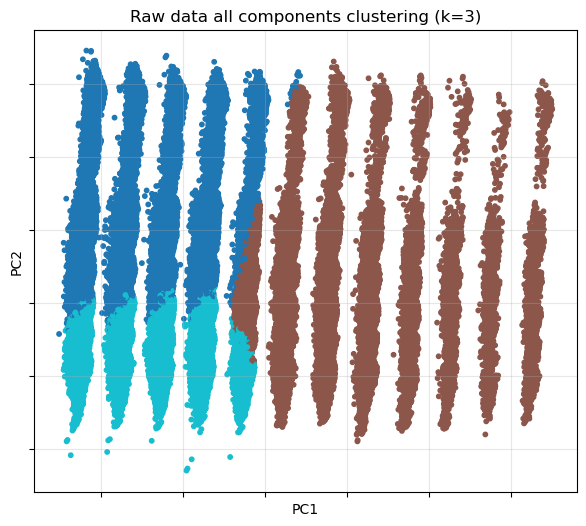

In [15]:
plt.figure(figsize=(7,6))
plt.scatter(Z_train[:,0], Z_train[:,1], c=cluster_train, cmap="tab10", s=10)
plt.title(f"Raw data all components clustering (k={k_best})")
plt.xlabel("PC1")
plt.ylabel("PC2")

ax = plt.gca()
ax.tick_params(labelbottom=False, labelleft=False)

plt.grid(True, alpha=0.3)
plt.show()


Performs KMeans clustering directly in a 2D PCA projection for an intuitive plot:  
- We use the Z_train from before again. 
- Fits a KMeans model with `k` clusters on `Z_train` and obtains cluster labels (`labels`) in this exact 2D space.
- Creates a scatter plot of the 2D PCA coordinates colored by these KMeans labels, showing cluster assignments that correspond directly to the visible point cloud.

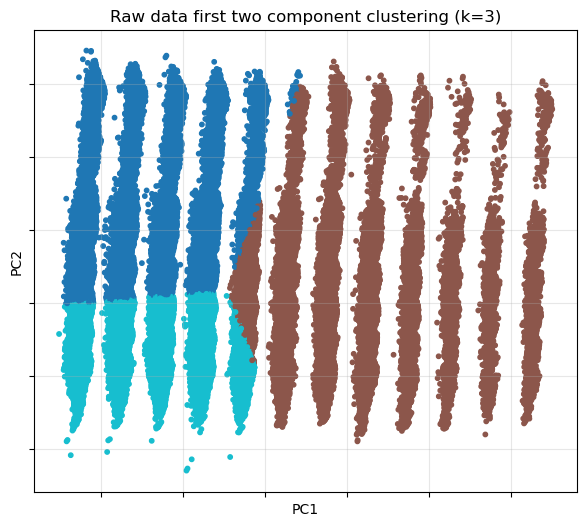

In [16]:
plt.figure(figsize=(7,6))
labels = KMeans(n_clusters=k_best, n_init="auto", random_state=42).fit_predict(Z_train[:,0:2])
sc = plt.scatter(Z_train[:,0], Z_train[:,1], c=labels, cmap="tab10", s=10)
plt.title(f"Raw data first two component clustering (k={k_best})")
plt.xlabel("PC1")
plt.ylabel("PC2")
ax = plt.gca()
ax.tick_params(labelbottom=False, labelleft=False)

plt.grid(True, alpha=0.3)
plt.show()